# CHAPTER 2 - Maintaining your Delta Lake

- lakehouse의 구성 요소
   - data storage
      - hdfs (+ parquet format)
   - metadata storage
      - rdb, file system
   - query engine


- warehouse -> datalake -> lakehouse
   - offline storage에서는 대용량 처리를 위해 데이터를 bulk 단위로 묶어서 관리 (online storage의 짧은 latency와 tradeoff)
   - structure the data (schema-on-write)
       - open table format https://aws.amazon.com/ko/blogs/tech/choosing-an-open-table-format-for-your-transactional-data-lake-on-aws/
          - 분석에 용이하도록 최적화된 테이블 형식의 데이터 포맷
       - schema 관리
   - 증분처리
      - streaming data
      - 스키마 변경
      - 버전 관리 및 복구
 
- 기존에 한계들을 어떻게 풀었는가?
  - 증분 데이터 처리 어려움. 파티션 관리 메뉴얼하게 호출. 트렌젝션을 위한 별도의 쿼리 엔진. 등등...
  - 빅데이터 스토리지가 online storage에 비해 부족한 부분들을 지속적으로 보강하면서 발전. 예) 하둡기반에서는 RDB의 많은 기능들을 포기.
- 이번 장에서는 deltalake의 기초적인 기능에 집중하고 (streaming은 다음 장에서 다룸) 이를 활용한 구조나 데이터 파이프라인이 어떻게 나올 수 있는 지와 같은 설계와 관련된 내용은 추후 구조 설명에서 나옴.

## 개요

- 키워드: 운영 (`maintaining`)
- 핵심 용어: `cleaning`, `tuning` + `repairing`, `restoring`, `replacing`
- 어떻게: `utility methods`, `configurations`
- (DeltaLake 시작 실습 (데이터 생성, 변경, 삭제) + 유지 보수 실습)

---

- the general process of `maintaining` our Delta Lake tables
  - assessing the situation and finding a solution 
- In essence, we just need to think in terms of `cleaning`, `tuning`, `repairing`, and `replacing`.
- we’ll learn to take advantage of the Delta Lake `utility methods` and learn about their associated `configurations` (aka table properties).




## 1. Using Delta Lake Table Properties

- table 정의할 때, `TBLPROPERTIES`로 table metadata를 저장할 수 있다.
- DeltaLake에서는 이 properties를 통해 유틸리티 메소드의 동작을 변경할 수 있다.

<div>
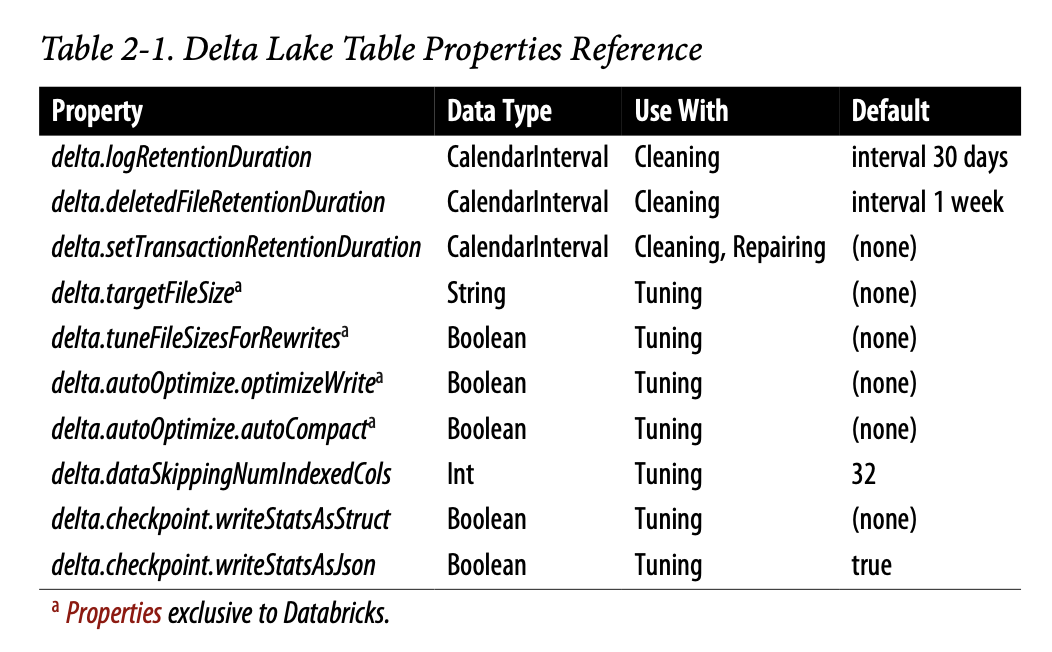
</div>

- 테이블의 변경은 batch의 경우는 다음 트랜젝션 동안에 적용되어 결과에 반영되고, streaming의 경우는 즉시 반영 된다.
- streaming 에서 table이나 table 메타데이터의 변경은 ALTER TABLE 과 같이 처리된다. (lock?) 그외 vacuum and optimize와 같은물리적인 테이블 데이터를 변경하지 않는 다른 변경은 흐름 중단 없이 외부에서 업데이트할 수 있다.
- 물리적인 테이블이나 데이블 메타데이터의 변경은 둘 다 동일하게 Delta Log에 버전 기록을 생성한다. 새로운 트랜젝션의 추가는 stale 처리를 위해 DeltaSnapshot의 로컬 동기화를 부른다. 이런 동작은 동시에 여러 writers와 분산 방식의 변경을 젝송하면서 Delta Log에 중앙와된 동기화응 제공하기 위함이다. https://docs.delta.io/latest/concurrency-control.html#write-conflicts

- 다른 활성 사용자와 충돌이 발생하는 동작(예: `REPLACE TABLE` 로 파티션 추가)이 있기 때문에 주의 깊게 사용해야하는 몇 가지 사례가 있다. 


### Create an `Empty` Table with Properties

In [1]:
table_name = "default.covid_nyt"

In [2]:
spark.sql(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
      date DATE
    ) USING DELTA
     TBLPROPERTIES('delta.logRetentionDuration'='interval 7 days');
""")

24/02/28 21:03:40 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/02/28 21:03:40 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/02/28 21:03:46 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/02/28 21:03:46 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.17.0.2
24/02/28 21:03:46 WARN ObjectStore: Failed to get database default, returning NoSuchObjectException
24/02/28 21:03:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/02/28 21:03:53 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`default`.`covid_nyt` into Hive metast

DataFrame[]

- `SQL CREATE TABLE` 문법으로 테이블을 생성하는 방법.
    - `USING`: https://spark.apache.org/docs/latest/sql-ref-syntax-ddl-create-table-datasource.html
- 본 예제에서는 초기에는 schema 없이 생성하고 이후에 데이터 기반으로 schema를 추론하여 결정하고 변경하도록 함. (schema-on-write)

### Populate the Table

- 이 시점에는 `/{tablename}/_delta_log` 만 존재
   - 초기 스키마를 포함한 로그와 빈 테이블의 메타데이터

In [3]:
spark.table(table_name).inputFiles()

24/02/28 21:03:54 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


[]

In [4]:
from pyspark.sql.functions import to_date
(spark.read
  .format("parquet")
  .load("/opt/spark/work-dir/rs/data/COVID-19_NYT/*.parquet")
  .withColumn("date", to_date("date", "yyyy-MM-dd"))
  .write
  .format("delta")
  .mode("append") # append를 명시하지 않는 경우 에러 발생: pyspark.sql.utils.AnalysisException: Table default.covid_nyt already exists
  .option("mergeSchema", "true") # pyspark.sql.utils.AnalysisException: A schema mismatch detected when writing to the Delta table (Table ID: xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx)
  .saveAsTable(table_name)
)

In [5]:
spark.table(table_name).inputFiles()

['file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt/part-00004-791a5597-4cde-416e-988d-f1ebd725a1df-c000.snappy.parquet',
 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt/part-00001-a5291b9f-5954-4679-95ae-cc93ee66e4ed-c000.snappy.parquet',
 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt/part-00002-d06c92b7-6d3b-4482-a63c-27628297d356-c000.snappy.parquet',
 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt/part-00000-4a6bb57d-eea4-46ad-9591-8a97b41fd3f9-c000.snappy.parquet',
 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt/part-00003-1fe983a7-8433-4be4-ae06-f78887cd59ea-c000.snappy.parquet',
 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt/part-00005-357ec1d5-e043-475a-a45f-05a89c638620-c000.snappy.parquet',
 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt/part-00006-7c2a8864-ab22-4dc6-9c8c-a06fdceee1ba-c000.snappy.parquet']

### Evolve the Table Schema

- `Schema Enforcement`: 쓰기 작업시 기존 스키마와 일치하는지 점검하고 불일치시 예외를 발생.
- `Schema Evolution`: 하위 호환을 유지하면서 스키마를 의도적으로 변경.
   - 예) `ALTER TABLE {t} ADD COLUMN(S)` / mergeSchema option

In [6]:
# .option("mergeSchema", "true")

- 스키마 변경을 명시적으로 하는 다른 방법: SQL의 `ALTER TABLE`
- schema를 자동 반영하게되면 갑작스러운 스키마 변경에 대해 복구하는 작업 비용이 크기 때문에 스키마 자동 변경은 하지 않고 명시적으로 변경하도록 하는 것을 권장.

In [7]:
# spark.sql("""
#         ALTER TABLE default.covid_nyt
#         ADD COLUMNS (
#           county STRING,
#           state STRING,
#           fips INT,
#           cases INT,
#           deaths INT
# ); """)

- `DESCRIBE TABLE`
- table 메타데이터 출력
- https://spark.apache.org/docs/3.3.1/sql-ref-syntax-aux-describe-table.html

In [8]:
spark.sql(f"describe extended {table_name}").show(truncate=False)

+----------------------------+----------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                     |comment|
+----------------------------+----------------------------------------------------------------------------------------------+-------+
|date                        |date                                                                                          |NULL   |
|county                      |string                                                                                        |NULL   |
|state                       |string                                                                                        |NULL   |
|fips                        |int                                                                                           |NULL   |
|cases                       |int                             

### Add or Modify Table Properties

In [9]:
spark.sql(f"""
      ALTER TABLE {table_name}
      SET TBLPROPERTIES (
        'engineering.team_name'='dldg_authors',
        'engineering.slack'='delta-users.slack.com'
      )
""")
# blindly overwrite

DataFrame[]

In [10]:
spark.sql(f"show tblproperties {table_name}").show(truncate=False)

+--------------------------+---------------------+
|key                       |value                |
+--------------------------+---------------------+
|delta.logRetentionDuration|interval 7 days      |
|delta.minReaderVersion    |1                    |
|delta.minWriterVersion    |2                    |
|engineering.slack         |delta-users.slack.com|
|engineering.team_name     |dldg_authors         |
+--------------------------+---------------------+



In [11]:
# https://docs.delta.io/latest/api/python/spark/index.html
from delta.tables import DeltaTable
dt = DeltaTable.forName(spark, table_name) 
dt.history(10).select("version", "timestamp", "operation").show(truncate=False)

+-------+-----------------------+-----------------+
|version|timestamp              |operation        |
+-------+-----------------------+-----------------+
|2      |2024-02-28 21:04:00.866|SET TBLPROPERTIES|
|1      |2024-02-28 21:03:58.786|WRITE            |
|0      |2024-02-28 21:03:48.25 |CREATE TABLE     |
+-------+-----------------------+-----------------+



In [12]:
dt.detail().select("properties").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+
|properties                                                                                                                        |
+----------------------------------------------------------------------------------------------------------------------------------+
|{delta.logRetentionDuration -> interval 7 days, engineering.team_name -> dldg_authors, engineering.slack -> delta-users.slack.com}|
+----------------------------------------------------------------------------------------------------------------------------------+



### Remove Table Properties

```py
misspelled_property = 'delta.loRgetentionDuratio'
```

```py
spark.sql(f"""
        ALTER TABLE default.covid_nyt
        SET TBLPROPERTIES('{misspelled_property}'='interval 7 days')
""")
```

```
AnalysisException: [DELTA_UNKNOWN_CONFIGURATION] Unknown configuration was specified: delta.loRgetentionDuratio
To disable this check, set spark.databricks.delta.allowArbitraryProperties.enabled=true in the Spark session configuration.
```


In [13]:
spark.sql(f"""
        ALTER TABLE {table_name}
        UNSET TBLPROPERTIES('engineering.team_name')
""")

DataFrame[]

In [14]:
dt.detail().select("properties").show(truncate=False)

+-------------------------------------------------------------------------------------------+
|properties                                                                                 |
+-------------------------------------------------------------------------------------------+
|{delta.logRetentionDuration -> interval 7 days, engineering.slack -> delta-users.slack.com}|
+-------------------------------------------------------------------------------------------+



#### (Spark Only) Default Table Properties

- SparkSession setting 방식
   - 이전에 table에 설정하는 방식은 Table setting
- `spark.databricks.delta.properties.defaults.<conf>`
   - `spark.databricks.delta.properties.defaults.logRetentionDuration=interval 2 weeks`
- 자동으로 주입할 기본 properties 값
- 소유자 관련 정보를 주입할 때 유용할 수 있다.

- 아래와 같이 `catalog` 접두어를 사용한 Data Cataloging을 위한 테이블 속성이 있다
```
catalog.team_name
catalog.engineering.comms.slack
catalog.engineering.comms.email
catalog.table.classification
```

## 2. Delta Table Optimization

#### 배경
- 각 operation (appended, updated, upserted, delted)은 atomic transaction (version, timestamp, operations, and more) 으로 관리된다. 
- table의 현 상태 뿐만 아니라 충분한 history를 유지하여 이전 상태로 복구도 가능하다.
   - to fix (overwrite), or recover (replace) 

### The Problem with Big Tables and Small Files

- small files: 64kb 이하의 파일
- 시간이 지남에 따라 해당 테이블의 처리 속도가 느려지는 등의 문제가 서서히 드러남.
- 전통적인 hadoop ecosystem 에서는 파일의 block 단위로 task가 생기는데 파일이 많아지면 결과적으로 task 수도 비효율적으로 많아지는 문제가 있음.

#### Creating the Small File Problem

In [15]:
!ls -lh /opt/spark/work-dir/share/spark-warehouse/covid_nyt/*.parquet | wc -l

7


In [16]:
dt = DeltaTable.forName(spark, table_name)
dt.toDF().count()

1111930

- 1,111,930개의 records가 7개의 파일로 분리되어 있다.
- 이를 9000개의 파일로 쪼개어 최적화되지 않는 상황을 재현해본다.
   - 이는 극단적인 예시이지만, streaming applications에서는 작은 크기의 파일이 많이 만들어지는 현상은 일반적인 문제 상황이다.

In [17]:
non_optimal_table_name = "default.nonoptimal_covid_nyt"

from delta.tables import DeltaTable
(DeltaTable.createIfNotExists(spark)
    .tableName(non_optimal_table_name)
    .property("description", "table to be optimized")
    .property("catalog.team_name", "dldg_authors")
    .property("catalog.engineering.comms.slack",
      "https://delta-users.slack.com/archives/CG9LR6LN4")
    .property("catalog.engineering.comms.email","dldg_authors@gmail.com")
    .property("catalog.table.classification","all-access")
    .addColumn("date", "DATE")
    .addColumn("county", "STRING")
    .addColumn("state", "STRING")
    .addColumn("fips", "INT")
    .addColumn("cases", "INT")
    .addColumn("deaths", "INT")
    .execute()
)

24/02/28 21:04:07 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`default`.`nonoptimal_covid_nyt` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


In [18]:
%%time
(spark
       .table(table_name)
       .repartition(9000)
       .write
       .format("delta")
       .mode("overwrite")
       .saveAsTable(non_optimal_table_name)
)

CPU times: user 1.71 s, sys: 800 ms, total: 2.51 s
Wall time: 3min 37s


In [19]:
!ls -l /opt/spark/work-dir/share/spark-warehouse/nonoptimal_covid_nyt/*parquet | wc -l

9000


### Using Optimize to Fix the Small File Problem

- optimize 방식: bin-packing(기본값), z-order

#### Optimize
- bin-packing: bin은 최대 사이즈의 제한이 있는 파일이며, 데이터가 임의의 개수의 bin에 배치된다.
  - small files -> large files 

- (spark only) `spark.databricks.delta.optimize.minFileSize` (long) 
- (spark only) `spark.databricks.delta.optimize.maxFileSize` (long)
- (spark-only) `spark.databricks.delta.optimize.repartition.enabled` (bool)
   - change the behavior of OPTIMIZE and will use `repartition(1)` instead of `coalesce(1)` when reducing
   - coalesce은 파티션을 줄이는 것만 가능하지만 보통의 경우 full 셔플이 발생하지 않기 떄문에 효율적.
- (delta-rs and non-OSS delta) The table property `delta.targetFileSize` (string)
   - delta-rs (rust) client 

- OPTIMIZE command는 deterministic

In [20]:
%%time

results_df = (DeltaTable
       .forName(spark, non_optimal_table_name)
       .optimize()
       .executeCompaction())
# results_df 은 최적화가 된 상태

24/02/28 21:07:46 WARN TaskSetManager: Stage 65 contains a task of very large size (1702 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 271 ms, sys: 125 ms, total: 396 ms
Wall time: 2min 34s


In [21]:
from pyspark.sql.functions import col
(DeltaTable.forName(spark, non_optimal_table_name)
    .history(10)
    .where(col("operation") == "OPTIMIZE")
    .select("version", "timestamp", "operation", "operationMetrics.numRemovedFiles", "operationMetrics.numAddedFiles")
    .show(truncate=False)
)

+-------+-----------------------+---------+---------------+-------------+
|version|timestamp              |operation|numRemovedFiles|numAddedFiles|
+-------+-----------------------+---------+---------------+-------------+
|2      |2024-02-28 21:10:18.443|OPTIMIZE |9000           |1            |
+-------+-----------------------+---------+---------------+-------------+



#### Z-Order Optimize
- https://www.youtube.com/watch?v=ncqSjHeZTxU
- https://delta.io/blog/2023-06-03-delta-lake-z-order/
- https://docs.delta.io/2.0.2/optimizations-oss.html#language-python

- 밀접한 관계가 있는 데이터들 끼리 같은 파일 set에 위치하도록 함.
- min, max와 같은 통계정보를 기반으로 탐색할 파일 범위를 줄이고 쿼리에 관련 없는 파일들은 skip 하여 쿼리를 빠르게 처리.
- 이 후에 자세히 설명


## 3. Table Tuning and Management

- 1TB 이하의 table에서는 바로 전에 소개된 OPTIMIZE 로도 충분하다. 하지만 시간이 지남에 따라 테이블이 커지면 partitioning 을 고려해야한다.

### Partitioning your Tables
- 파티션을 나눌 때, 경우에 따라 작은 파일이 생성되는 문제가 발생할 수 있지만 해당 디렉토리 레벨(특정 파티션)에서만 영향을 미친다.
- 어떻게 파티션 규칙을 설정해야 좋은가?

#### Table Partitioning Rules
- 1. 테이블이 1TB 이하인 경우, partitioning을 고려하지 않아도 된다. 단순히 OPTIMIZE로 파일 수를 줄여도 충분하다.
   - bin-packing을 통한 performance 향상이 충분하지 않는 경우 자주 사용되는 쿼리를 고려하여 z-order 최적화를 통해 쿼리와 관련된 데이터를 같이 위치시켜서 성능 향상을 시도할 수 있다.
- 2. 데이터 삭제를 최적화해야 하는 경우, partitioning을 고려할 수 있다. 예를 들어 일 별로 파티셔닝하고 30일 데이터를 유지하는 경우 기간이 지난 데이터를 삭제하면 특정 파티션을 삭제하게 된다.

#### Choose the right partition column
- 가장 일반적으로 파티셔닝을 위해 선택하는 column은 date이다.
- 1. column의 cardinality가 매우 높은 경우 파티셔닝할 column으로 사용하면 안 된다. 예를 들어 userId의 경우 유일한 값들이고 이를 파티셔닝하면 각 파티션에 하나의 레코드만 가지게 된다. (값의 범위로 분리하고 cardinality를 줄인 새로운 column을 생성하면 가능할 듯)
- 2. 각 파티션에는 최소한 1GB 데이터를 가지고 있으면 좋다.

### Defining Partitions on Table Creation
- `addColumn("date", DateType(), nullable=False)`
  - 파티셔닝할 column에 non-nullable flag
- `partitionBy("date")`
- 각 파티션마다 물리적인 디렉토리를 사용한다.

In [22]:
partitioning_table_name = "default.covid_nyt_by_date"


from pyspark.sql.types import DateType
from delta.tables import DeltaTable
(DeltaTable.createIfNotExists(spark)
    .tableName(partitioning_table_name)
    .addColumn("date", DateType(), nullable=False)
    .partitionedBy("date")
    .addColumn("county", "STRING")
    .addColumn("state", "STRING")
    .addColumn("fips", "INT")
    .addColumn("cases", "INT")
    .addColumn("deaths", "INT")
    .execute()
)

24/02/28 21:10:21 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`default`.`covid_nyt_by_date` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


### Migrating from a Non-Partitioned to Partitioned Table
- 파티셔닝의 변경을 물리적인 변경을 발생시키기 때문에 가장 손쉬운 마이그레이션 방식은 새로운 table을 만들고 data customers에게 새로운 table을 가이드 하는 것이다.
- 이 예제에서는 이전 테이블에서 (non-partitioned) 새로운 테이블(partitioned)로 단순 복사하는 마이그레이션을 보여준다.
- (live downstream customers를 고려해야하는 경우: customer가 마이그레이션을 완전히 마칠 때까지 dual copy를 계속해야한다. 이후 장에서 좀 더 고도화된 증분 처리를 통해 두 테이블의 동기화를 위해 점진적인 merge 방식을 보여준다.)

In [23]:
(spark
     .table(table_name)
     .write
     .format("delta")
     .mode("append")
     .option("mergeSchema", "false")
     .saveAsTable(partitioning_table_name)
)

#### Partition Metadata Management
`ALTER TABLE table_name [ADD | DROP PARTITION] (column=value)` 과 같이 새로운 파티션이 추가되거나 삭제될때마다 manually 처리를 하지 않아도 DeltaLake는 자동으로 새로운 데이터나 데이터 삭제에 대하여 파티션을 관리해준다

#### Viewing Partition Metadata

In [24]:
json_str = (DeltaTable.forName(spark, partitioning_table_name)
    .detail()
    .toJSON()
    .collect()[0]
)

import json
json.loads(json_str)

{'format': 'delta',
 'id': 'e7b71924-d155-4f03-8ba9-ee0415200c4c',
 'name': 'spark_catalog.default.covid_nyt_by_date',
 'location': 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date',
 'createdAt': '2024-02-28T21:10:20.277Z',
 'lastModified': '2024-02-28T21:10:40.751Z',
 'partitionColumns': ['date'],
 'numFiles': 422,
 'sizeInBytes': 17656269,
 'properties': {},
 'minReaderVersion': 1,
 'minWriterVersion': 2,
 'tableFeatures': ['appendOnly', 'invariants']}

## 4. Repairing, Restoring, and Replacing Table Data

- data engineer가 데이터에 치명적인 문제가 생겼을 때, 복구해야한다.
- restoring을 `replaying`이라고도 부름

### Recovering and Replacing Tables
- 데이터를 복구할 때 중요한 점은 현재 문제가 있는 테이블보다 더 좋은 상태인 데이터소스가 필요하다는 것이다.
- 나중에 소개할 Medallion Architecture는  raw (bronze), cleansed (silver), and curated (gold) data sets으로 구분하고 이들의 데이터 품질의 경계를 명확하게 정의한다.
- 아래 예제에서는 bronze database에 원본 table이 있고, silver database에 있는 망가진 table을 bronze 데이터를 가져다가 복구하는 것을 보여준다.

#### Conditional Table Overwrites using ReplaceWhere

- replace overwrite pattern
   - target table에서 조건에 맞는 데이터를 지우고, 신규 데이터 중 조건에 맞는 데이터를 쓰기.
     - `spark.databricks.delta.replaceWhere.constraintCheck.enabled` 신규 데이터에 조건에 맞지 않는 데이터도 쓰려면 이 설정을 비활성화하고 쓸 수도 있음. 
- 2021-02-17 날짜 데이터가 지워졌다고 가정하고 bronze 에서 silver로 가지고 오는 예시 코드
   - where 절을 guard rail 역할로 실수로 다른 데이터가 영향이 미치는 것을 사전에 예방하는 의도.

In [25]:
# recovery_table = spark.table("bronze.covid_nyt_by_date")

# partition_col = "date"
# partition_to_fix = "2021-02-17"
# table_to_fix = "silver.covid_nyt_by_date"

# (recovery_table
# .where(col(partition_col) == partition_to_fix)
# .write
# .format("delta")
# .mode("overwrite")
# .option("replaceWhere", f"{partition_col} == {partition_to_fix}")
# .saveAsTable("silver.covid_nyt_by_date")
# )

#### Deleting Data and Removing Partitions

In [26]:
import json
dt = DeltaTable.forName(spark, partitioning_table_name)
tmp_json_str = dt.detail().toJSON().collect()[0]
json.loads(tmp_json_str)

{'format': 'delta',
 'id': 'e7b71924-d155-4f03-8ba9-ee0415200c4c',
 'name': 'spark_catalog.default.covid_nyt_by_date',
 'location': 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date',
 'createdAt': '2024-02-28T21:10:20.277Z',
 'lastModified': '2024-02-28T21:10:40.751Z',
 'partitionColumns': ['date'],
 'numFiles': 422,
 'sizeInBytes': 17656269,
 'properties': {},
 'minReaderVersion': 1,
 'minWriterVersion': 2,
 'tableFeatures': ['appendOnly', 'invariants']}

In [27]:
import pyspark.sql.functions as F
target_recode_count = dt.toDF().where(
    F.col('date') < F.lit('2021-01-01').cast('date')
).count()

target_recode_count

884737

In [28]:
all_count = dt.toDF().count()
all_count

1111930

In [29]:
next_result_count = all_count - target_recode_count
next_result_count

227193

In [30]:
!du -shc /opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date

20M	/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date
20M	total


In [31]:
dt.delete(F.col("date") < F.lit('2021-01-01').cast('date'))

- table recode는 삭제했지만 히스토리를 위해 지운 데이터가 남아 있기 때문에 용량은 유지

In [32]:
!du -shc /opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date

20M	/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date
20M	total


In [33]:
dt.toDF().count()

227193

In [34]:
import json
dt = DeltaTable.forName(spark, partitioning_table_name)
tmp_json_str = dt.detail().toJSON().collect()[0]
json.loads(tmp_json_str)

{'format': 'delta',
 'id': 'e7b71924-d155-4f03-8ba9-ee0415200c4c',
 'name': 'spark_catalog.default.covid_nyt_by_date',
 'location': 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date',
 'createdAt': '2024-02-28T21:10:20.277Z',
 'lastModified': '2024-02-28T21:10:47.359Z',
 'partitionColumns': ['date'],
 'numFiles': 72,
 'sizeInBytes': 3838534,
 'properties': {},
 'minReaderVersion': 1,
 'minWriterVersion': 2,
 'tableFeatures': ['appendOnly', 'invariants']}

### The Lifecycle of a Delta Lake Table

- delta.logRetentionDuration 을 충분히 길게 설정하여 이전 버전의 이력을 충분히 확보할 수 있도록 해야한다.
- 테이블의 변경은 각각 복원이나 이전 시점의 table을 보거나 다양한 시점의 table을 streaming으로 깔끔하게 제공하기 위해 변경 이력을 디스크에 남겨둔다.

### Restoring your Table

In [35]:
(dt.history(10)
.select("version", "timestamp", "operation")
.show(
    truncate=False
))

+-------+-----------------------+------------+
|version|timestamp              |operation   |
+-------+-----------------------+------------+
|2      |2024-02-28 21:10:47.359|DELETE      |
|1      |2024-02-28 21:10:40.751|WRITE       |
|0      |2024-02-28 21:10:20.357|CREATE TABLE|
+-------+-----------------------+------------+



In [36]:
%%time
dt.restoreToVersion(1)

24/02/28 21:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1062.4 KiB


CPU times: user 15.1 ms, sys: 10.5 ms, total: 25.6 ms
Wall time: 6.96 s


DataFrame[table_size_after_restore: bigint, num_of_files_after_restore: bigint, num_removed_files: bigint, num_restored_files: bigint, removed_files_size: bigint, restored_files_size: bigint]

In [37]:
import json
dt = DeltaTable.forName(spark, partitioning_table_name)
tmp_json_str = dt.detail().toJSON().collect()[0]
json.loads(tmp_json_str)

24/02/28 21:10:57 ERROR NonFateSharingFuture: Failed to get result from future
scala.runtime.NonLocalReturnControl


{'format': 'delta',
 'id': 'e7b71924-d155-4f03-8ba9-ee0415200c4c',
 'name': 'spark_catalog.default.covid_nyt_by_date',
 'location': 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date',
 'createdAt': '2024-02-28T21:10:20.277Z',
 'lastModified': '2024-02-28T21:10:55.019Z',
 'partitionColumns': ['date'],
 'numFiles': 422,
 'sizeInBytes': 17656269,
 'properties': {},
 'minReaderVersion': 1,
 'minWriterVersion': 2,
 'tableFeatures': ['appendOnly', 'invariants']}

In [38]:
dt.toDF().count()

1111930

In [39]:
(dt.history(10)
.select("version", "timestamp", "operation")
.show(
    truncate=False
))

+-------+-----------------------+------------+
|version|timestamp              |operation   |
+-------+-----------------------+------------+
|3      |2024-02-28 21:10:55.019|RESTORE     |
|2      |2024-02-28 21:10:47.359|DELETE      |
|1      |2024-02-28 21:10:40.751|WRITE       |
|0      |2024-02-28 21:10:20.357|CREATE TABLE|
+-------+-----------------------+------------+



### Cleaning Up

- 테이블에서 데이터 삭제를 하면 실제 데이터가 즉시 없어지는 것이 아니라 reference만 제거해서 안 보이게 한다. (복구해야하니까 이전 데이터를 남겨둬야함)
- vacuuming이라고 불리는 프로세스를 사용하여 삭제를 요청한 데이터를 실제로 제거(purge)할 수 있다.
- vacuum

#### Vacuum

In [40]:
# partitioning_table_name = "default.covid_nyt_by_date"

target_table_name_for_vacuum_test = partitioning_table_name

In [41]:
from delta.tables import DeltaTable
dt = DeltaTable.forName(spark, target_table_name_for_vacuum_test)

In [42]:
(dt.history(10)
.select("version", "timestamp", "operation")
.show(
    truncate=False
))

+-------+-----------------------+------------+
|version|timestamp              |operation   |
+-------+-----------------------+------------+
|3      |2024-02-28 21:10:55.019|RESTORE     |
|2      |2024-02-28 21:10:47.359|DELETE      |
|1      |2024-02-28 21:10:40.751|WRITE       |
|0      |2024-02-28 21:10:20.357|CREATE TABLE|
+-------+-----------------------+------------+



In [43]:
%%time
dt.restoreToVersion(2)

24/02/28 21:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1062.8 KiB


CPU times: user 8.44 ms, sys: 3.38 ms, total: 11.8 ms
Wall time: 6.09 s


DataFrame[table_size_after_restore: bigint, num_of_files_after_restore: bigint, num_removed_files: bigint, num_restored_files: bigint, removed_files_size: bigint, restored_files_size: bigint]

In [44]:
json_str = (dt.detail()
    .toJSON()
    .collect()[0]
)

import json
json.loads(json_str)

24/02/28 21:11:05 ERROR NonFateSharingFuture: Failed to get result from future
scala.runtime.NonLocalReturnControl


{'format': 'delta',
 'id': 'e7b71924-d155-4f03-8ba9-ee0415200c4c',
 'name': 'spark_catalog.default.covid_nyt_by_date',
 'location': 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date',
 'createdAt': '2024-02-28T21:10:20.277Z',
 'lastModified': '2024-02-28T21:11:03.323Z',
 'partitionColumns': ['date'],
 'numFiles': 72,
 'sizeInBytes': 3838534,
 'properties': {},
 'minReaderVersion': 1,
 'minWriterVersion': 2,
 'tableFeatures': ['appendOnly', 'invariants']}

In [45]:
spark.sql(f"""
      ALTER TABLE {target_table_name_for_vacuum_test}
      SET TBLPROPERTIES (
        'delta.deletedFileRetentionDuration'='interval 1 seconds',
        
        'delta.logRetentionDuration'='interval 1 seconds',
        'delta.checkpointInterval'='1'
      )
""")

DataFrame[]

In [46]:
spark.sql(f"show tblproperties {target_table_name_for_vacuum_test}").show(truncate=False)

+----------------------------------+------------------+
|key                               |value             |
+----------------------------------+------------------+
|delta.checkpointInterval          |1                 |
|delta.deletedFileRetentionDuration|interval 1 seconds|
|delta.logRetentionDuration        |interval 1 seconds|
|delta.minReaderVersion            |1                 |
|delta.minWriterVersion            |2                 |
+----------------------------------+------------------+



In [47]:
json_str = (dt.detail()
    .toJSON()
    .collect()[0]
)

import json
json.loads(json_str)

24/02/28 21:11:07 ERROR NonFateSharingFuture: Failed to get result from future
scala.runtime.NonLocalReturnControl


{'format': 'delta',
 'id': 'e7b71924-d155-4f03-8ba9-ee0415200c4c',
 'name': 'spark_catalog.default.covid_nyt_by_date',
 'location': 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date',
 'createdAt': '2024-02-28T21:10:20.277Z',
 'lastModified': '2024-02-28T21:11:06.522Z',
 'partitionColumns': ['date'],
 'numFiles': 72,
 'sizeInBytes': 3838534,
 'properties': {'delta.deletedFileRetentionDuration': 'interval 1 seconds',
  'delta.logRetentionDuration': 'interval 1 seconds',
  'delta.checkpointInterval': '1'},
 'minReaderVersion': 1,
 'minWriterVersion': 2,
 'tableFeatures': ['appendOnly', 'invariants']}

In [48]:
import time
time.sleep(1)

In [49]:
!du -shc /opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date

21M	/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date
21M	total


In [50]:
%%time

dt.vacuum()

24/02/28 21:11:32 ERROR NonFateSharingFuture: Failed to get result from future  
scala.runtime.NonLocalReturnControl


Deleted 350 files and directories in a total of 417 directories.
CPU times: user 136 ms, sys: 47.3 ms, total: 183 ms
Wall time: 24.8 s


DataFrame[]

- 실제 파일이 지워졌기 떄문에 용량이 줄어듬.

In [51]:
!du -shc /opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date

5.1M	/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date
5.1M	total


In [52]:
spark.sql(f"show tblproperties {target_table_name_for_vacuum_test}").show(truncate=False)

+----------------------------------+------------------+
|key                               |value             |
+----------------------------------+------------------+
|delta.checkpointInterval          |1                 |
|delta.deletedFileRetentionDuration|interval 1 seconds|
|delta.logRetentionDuration        |interval 1 seconds|
|delta.minReaderVersion            |1                 |
|delta.minWriterVersion            |2                 |
+----------------------------------+------------------+



In [53]:
json_str = (dt.detail()
    .toJSON()
    .collect()[0]
)

import json
json.loads(json_str)

24/02/28 21:11:36 ERROR NonFateSharingFuture: Failed to get result from future
scala.runtime.NonLocalReturnControl


{'format': 'delta',
 'id': 'e7b71924-d155-4f03-8ba9-ee0415200c4c',
 'name': 'spark_catalog.default.covid_nyt_by_date',
 'location': 'file:/opt/spark/work-dir/share/spark-warehouse/covid_nyt_by_date',
 'createdAt': '2024-02-28T21:10:20.277Z',
 'lastModified': '2024-02-28T21:11:33.552Z',
 'partitionColumns': ['date'],
 'numFiles': 72,
 'sizeInBytes': 3838534,
 'properties': {'delta.deletedFileRetentionDuration': 'interval 1 seconds',
  'delta.logRetentionDuration': 'interval 1 seconds',
  'delta.checkpointInterval': '1'},
 'minReaderVersion': 1,
 'minWriterVersion': 2,
 'tableFeatures': ['appendOnly', 'invariants']}

- vacuum은 로그 파일은 삭제하지 않고 데이터 파일만 삭제
- logRetentionDuration 의 적용은 checkpoint 생성 후에 자동으로 처리 ?? - 확인 불가...
- https://docs.delta.io/2.0.2/delta-utility.html#remove-files-no-longer-referenced-by-a-delta-table

In [54]:
(dt.history(10)
.select("version", "timestamp", "operation")
.show(
    truncate=False
))

+-------+-----------------------+-----------------+
|version|timestamp              |operation        |
+-------+-----------------------+-----------------+
|7      |2024-02-28 21:11:33.552|VACUUM END       |
|6      |2024-02-28 21:11:28.479|VACUUM START     |
|5      |2024-02-28 21:11:06.522|SET TBLPROPERTIES|
|4      |2024-02-28 21:11:03.323|RESTORE          |
|3      |2024-02-28 21:10:55.019|RESTORE          |
|2      |2024-02-28 21:10:47.359|DELETE           |
|1      |2024-02-28 21:10:40.751|WRITE            |
|0      |2024-02-28 21:10:20.357|CREATE TABLE     |
+-------+-----------------------+-----------------+



#### Dropping Tables

In [55]:
!ls -lh /opt/spark/work-dir/share/spark-warehouse/ | grep covid_nyt_by_date

drwxr-xr-x   419 NBuser NBuser  14K Feb 28 21:10 covid_nyt_by_date


In [56]:
spark.sql(f"drop table {target_table_name_for_vacuum_test}")

DataFrame[]

In [57]:
!ls -l /opt/spark/work-dir/share/spark-warehouse/ | grep covid_nyt_by_date

## 5. Summary

- Delta Lake의 the common utility functions
- create, alter, delete table
- table properties
- optimize, small files problem
- partitioning
- restoring, replacing

# END

In [58]:
!rm -rf /opt/spark/work-dir/share/spark-warehouse

In [59]:
!rm -rf /opt/spark/work-dir/share/metastore_db